# Progress Report

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Environment

The project is expected to run in a virtual environment in python 3.10.8. Please install the necessary packages from `requirements.txt`. Only Windows and MacOS (MPS) are supported at this time.

# Project Flow

In [13]:
# project flow -description & diagram 
# overall result (walkthrough like the app...?)

## Data Collection

In our project proposal we decided to use the [WikiART General Dataset](https://github.com/asahi417/wikiart-image-dataset?tab=readme-ov-file#wikiart-general). However, the dataset had issues with metadata file and with missing/duplicate images. Additionally, it didn't have all the classes we wanted for a good representation of notable art styles. We decided to make our own dataset called [wikiART224](https://drive.google.com/file/d/1sCCx07IUIdjS5aSDCpTQyV9SWzY-AjXN/view?usp=drive_link) and [wikiART9](https://drive.google.com/file/d/1xAETK5FzFYe7vsyITIFTRhtTWco_AnVF/view?usp=sharing), which we cited as an alternative in our proposal [(WikiArt Dataset)](https://archive.org/details/wikiart-dataset).

wikiART224 is created by adding zero-padding to the smallest dimension of the image until we reach 1:1 aspect ratio. The image is then resized to 224x224 for ResNET.
wikiART9 is created by adding zero-padding to the smallest dimension of the image until we reach 1:1 aspect ratio. The image is then segmented into a 3x3 grid and then each subimage is resized to 224x224 for ResNET. The resulting metadata can be found in [`labels.csv`](https://docs.google.com/spreadsheets/d/18SrwCjfP3gplKnSfoyhFhL3PrOB6y_zlf6TWNyFgIiQ/edit?usp=drive_link). The target classes are *art style* and *genre*.

The datasets were created using the following python files: `data_clean.ipynb` and `data_process.ipynb`. The first file was used to clean/correct the dataset's metadata by adding in artist, style, and genre information which was partially missing from the source dataset's metadata as only some labels were in the `classes.php` file. The second file was used to transform the source data into our datasets. Both the datasets and metadata is hosted on our project's Google Drive. The python files are hosted on the project github, it is not suggested to run them as it will take a long time due to the size of the datasets (32 GB).

### Summary of Data

*Please note that wikiART9 has 9x the images of wikiART224 but the exact same distributions as they are subimages. The data will not be plotted twice for brevity.*

In [3]:
import pandas as pd
file_path = 'Dataset\\labels.csv'
df = pd.read_csv(file_path)

In [9]:
print(f"Number of samples - wikiART224: {df.shape[0]}")
print(f"Number of samples - wikiART9: {9*df.shape[0]}")

Number of samples - wikiART224: 81444
Number of samples - wikiART9: 732996


We have 81444 and 732996 samples for wikiART224 and wikiART9, respectively.

In [5]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)

In [6]:
# Show distribtion (barplot) art style
fig_art_style = px.bar(df['art_style'].value_counts(), x=df['art_style'].value_counts().index, y=df['art_style'].value_counts().values, labels={'y': 'Count', 'x': 'Art Style'},
                       title='Distribution of Data by Art Style')
fig_art_style.update_layout(width=1000, height=500)
fig_art_style.show()

In [7]:
# Calculate the proportion of NaN values in the genre
nan_proportion_genre = df['genre'].isna().sum() / len(df)
# Create a pie chart for the proportion of NaN values in genre
fig_nan_genre = px.pie(names=['Missing Values', 'Present Values'],
                      values=[nan_proportion_genre, 1 - nan_proportion_genre],
                      title='Proportion of Missing Values in Genre Column')
fig_nan_genre.update_layout(width=600, height=400)
fig_nan_genre.show()

The data on wikiART does not have labels for genre for all images. Around 20% are unlabelled or belong to an other class with low representation. 

In [8]:
# Show distribtion (barplot) genre
fig_genre = px.bar(df['genre'].value_counts(), x=df['genre'].value_counts().index, y=df['genre'].value_counts().values, labels={'y': 'Count', 'x': 'Genre'},
                   title='Distribution of Data by Genre')
fig_genre.update_layout(width=800, height=500)
fig_genre.show()

## Results Achieved

### 1. Style Classification Model

Please note that not all the codes are given below. Only the essential codes are shown for visibility. 

In [ ]:
# needed libraries
import os
import zipfile

import random
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset

from PIL import Image
import csv

from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

from collections import Counter

#### 1.1 Data Loading

WikiART224 images are used to solve the style classification problem. Transformation of normalization is applied to each images and loaded to train, validation, test loader by custom_dataloader function. The ratio of each dataset is 8:1:1.
 
In the beginning, the model performance wasn't improving enough when all 27 classes of the style images were used for fine tuning. Therefore, it was decided to drop classes with small number of images and use only 13 styles as the subset data. The fact that there is a data imbalance and differentiating between some style classes is difficult also support this decision. The selected classes are as follows. 

In [ ]:
used_class = ['Abstract_Expressionism',
              'Art_Nouveau_Modern',
              'Baroque',
              'Cubism',
              'Expressionism',
              'Impressionism',
              'Naive_Art_Primitivism',
              'Northern_Renaissance',
              'Post_Impressionism',
              'Realism',
              'Rococo',
              'Romanticism',
              'Symbolism']

In [ ]:
# image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:

def custom_dataloader(data_dir, transform, batch_size=64, num_workers=1):
  raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  print(raw_dataset)

  num_classes = len(raw_dataset.classes)
  print("Number of classes:", num_classes)

  np.random.seed(1000) 
  indices = np.arange(len(raw_dataset))
  np.random.shuffle(indices)
  train_split = int(len(indices) * 0.8)
  testval_split = train_split + int(len(indices) * (1 - 0.8)/2)

  # split into training and validation indices
  relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
  print(f'data loading completed')
  return train_loader, val_loader, test_loader

To run the code, directories below should be modified. 

In [ ]:
### MODIFY ###
'''
rawdata_dir: file path of the extracted data. e.g. /file/path/of/data/folder
save_dir: file path for the saved data. e.g. /file/path/to/save/results/
'''
rawdata_dir = '/content/extracted_data_subset13'
save_dir = '/content/drive/MyDrive/UofT/MIE1517/project/subset fine tune/'

In [ ]:
train_loader, val_loader, test_loader = custom_dataloader(rawdata_dir, transform)

Dataset ImageFolder
    Number of datapoints: 69125
    Root location: /content/extracted_data_subset13/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Number of classes: 13
data loading completed


Samples of the images used are visualized as below. The images look darker than the original ones because it was normalized.

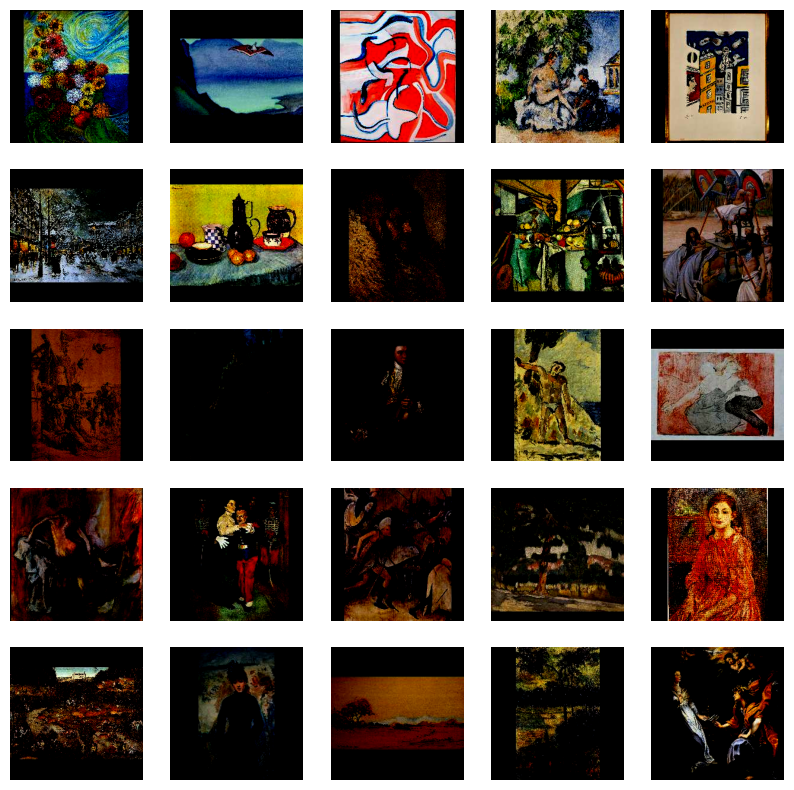

#### 1.2 Model Architecture

In [11]:
#### architecture diagram 

In [ ]:
class StyleResNet50_5(nn.Module):
  def __init__(self, hidden_dim1=1024, hidden_dim2=256):
    super(StyleResNet50_5, self).__init__()

    resnet = models.resnet50(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(2048, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3 = nn.Linear(hidden_dim2, 13)
    self.dropout = nn.Dropout(p=0.5)
    self.flatten = nn.Flatten()
    self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)


  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.leaky_relu(self.fc1(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

#### 1.3 Training

Training code is as follows. Every epoch took about 10 minutes in colab environment. 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

In [ ]:
def train_model(model, model_name, train_loader, valid_loader, device, save_dir, num_epochs=4, lr=0.0001, wd=0, clip_gradient=None):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        tqdm_bar = tqdm(train_loader)

        for batch_idx, (inputs, labels) in enumerate(tqdm_bar):
            with torch.set_grad_enabled(True):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                if clip_gradient is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                pred = outputs.max(1, keepdim=True)[1]
                running_pred += pred.eq(labels.view_as(pred)).sum().item()
                running_total += pred.shape[0]


        train_acc = running_pred / running_total
        train_loss = running_loss / running_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        valid_loss, valid_acc = evaluate_model(model, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
        model.train()

        joblib.dump(model, f'{save_dir}{model_name}_epoch{epoch+1}.joblib')

        results = pd.DataFrame({'train loss': train_losses, 'valid loss': valid_losses, 'train accuracy': train_accuracies, 'valid accuracy': valid_accuracies})
        results.to_csv(f'{save_dir}{model_name}_results.csv')
    end_time = time.time()
    elapsed_time = end_time - start_time
    plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time)


    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

Additional utility function are as given below

In [ ]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time):
    print(f'elapsed time: {elapsed_time}')
    iterations = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, label='Train Loss', color='blue')
    plt.plot(iterations, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    epochs = range(1, len(train_accuracies) + 1)
    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)
          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()
          total_samples += data.size(0)

    accuracy = total_correct / total_samples
    average_loss = total_loss / total_samples

    return average_loss, accuracy

#### 1.4 Results

After various hyperparameter tuning and modification of last fully connected layers, given architecture explained in 1.3 with learning rate 0.00001, clip gradient 1.0 and epoch 4 was selected as the best model. The training curve is given as below. 

In [ ]:
model = StyleResNet50_5()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50_5', train_loader, val_loader, device, save_dir, num_epochs = 5, clip_gradient=1.0)

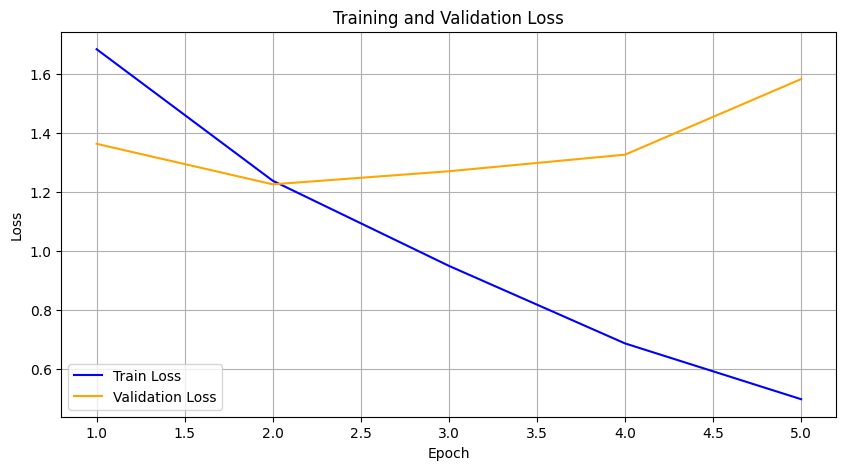
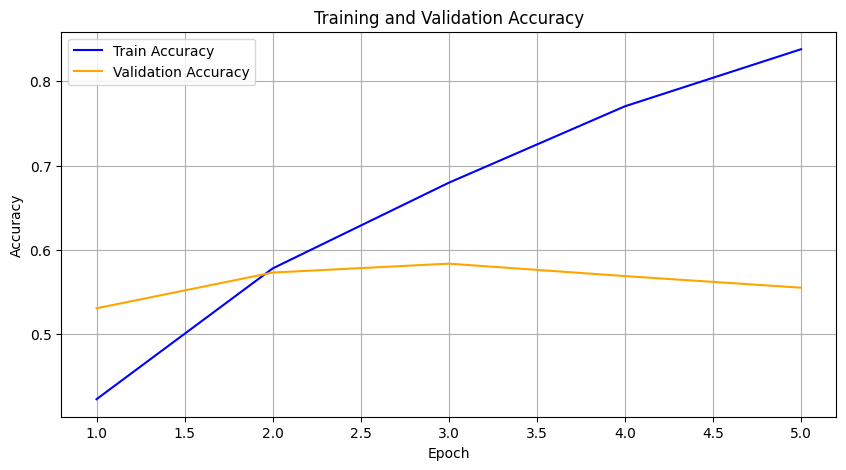

As can be seen with the training curves, the train accuracy goes up to 80% but the validation and test accuracy is quite low, reaching 58% for the maximum. We introduced a new metric top-3-accuracy to evaluate the model performance. Top-3-accuracy computes the number of times where the correct label is among the top 3 labels predicted. Since there are similar styles and styles which overlap, top-3-accuracy can be a reasonable metric to evaluate the style classification. With top-3-accuracy, the trained model exhibits a reasonably good performance. 

In [4]:
losses = pd.read_csv('style_cnn_kaccuracy.csv', index_col=0) 
losses

losses  accuracy  k accuracy
train  0.588948  0.803671    0.962333
val    1.270694  0.583623    0.865307
test   1.270794  0.587444    0.862867


To further validate the suitability of top-k-accuracy as a metric, we analyzed the probability distribution of the top predictions for images that were misclassified but still contained the true label within the top 3 predictions. The analysis revealed that the misclassified probability hovered around 50%, indicating that even in cases of misclassification, the correct label still often have a relatively high probability among the top predictions.

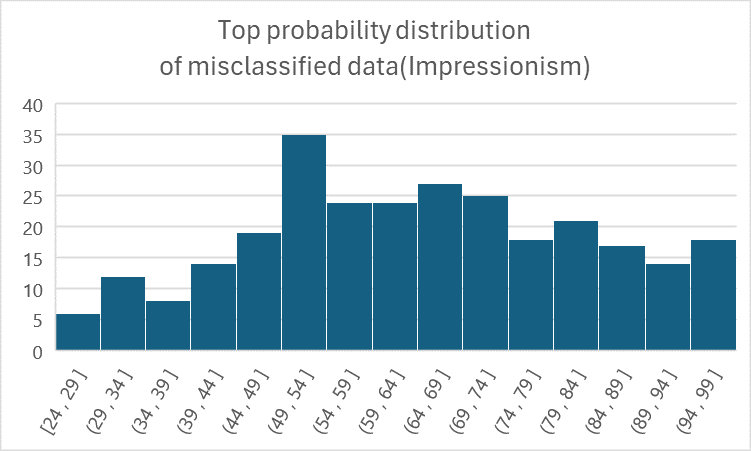

The analysis of precision, recall, and F1 score reveals that post-impressionism, expressionism, and symbolism exhibit the lowest F1 scores for the validation set. This outcome primarily stems from the model's tendency to misclassify a significant portion of expressionism images as post-impressionism. This result is understandable given the similarities between post-impressionism and expressionism, both of which often feature bold colors and dynamic brushwork, as exemplified in the provided example. Furthermore, the categorization of symbolism as an art movement rather than a consistent style leads to varied predictions across different styles, contributing to the low F1 score.

In [2]:
precision_metrics = pd.read_csv('style_cnn_precision_metrics.csv', index_col=0) 
precision_metrics

train precision  val precision  test precision  \
Abstract_Expressionism         0.828008       0.609195        0.662069   
Art_Nouveau_Modern             0.826470       0.630178        0.625668   
Baroque                        0.865530       0.645161        0.643172   
Cubism                         0.877181       0.712418        0.750000   
Expressionism                  0.780848       0.501859        0.478689   
Impressionism                  0.845899       0.680534        0.694570   
Naive_Art_Primitivism          0.843149       0.626667        0.662252   
Northern_Renaissance           0.932958       0.802326        0.795122   
Post_Impressionism             0.639342       0.434426        0.398524   
Realism                        0.748386       0.514844        0.523988   
Rococo                         0.823860       0.560000        0.612440   
Romanticism                    0.852184       0.579023        0.598829   
Symbolism                      0.861722       0.642361        0.613333   

                        train recall  val recall  test recall  train f1  \
Abstract_Expressionism      0.942947    0.770909     0.683274  0.881748   
Art_Nouveau_Modern          0.758074    0.514493     0.528217  0.790796   
Baroque                     0.909251    0.668258     0.703614  0.886852   
Cubism                      0.742614    0.473913     0.502041  0.804308   
Expressionism               0.695853    0.397644     0.445802  0.735904   
Impressionism               0.832359    0.676287     0.685778  0.839074   
Naive_Art_Primitivism       0.696721    0.417778     0.452489  0.762973   
Northern_Renaissance        0.908774    0.736655     0.654618  0.920707   
Post_Impressionism          0.756606    0.566412     0.533773  0.693048   
Realism                     0.864515    0.660781     0.651445  0.802270   
Rococo                      0.870392    0.551724     0.627451  0.846487   
Romanticism                 0.813904    0.562064     0.591040  0.832604   
Symbolism                   0.644550    0.405702     0.379381  0.737480   

                          val f1   test f1  
Abstract_Expressionism  0.680578  0.672504  
Art_Nouveau_Modern      0.566489  0.572827  
Baroque                 0.656506  0.672037  
Cubism                  0.569191  0.601467  
Expressionism           0.443714  0.461660  
Impressionism           0.678404  0.690146  
Naive_Art_Primitivism   0.501333  0.537634  
Northern_Renaissance    0.768089  0.718062  
Post_Impressionism      0.491716  0.456338  
Realism                 0.578755  0.580806  
Rococo                  0.555831  0.619855  
Romanticism             0.570418  0.594909  
Symbolism               0.497312  0.468790

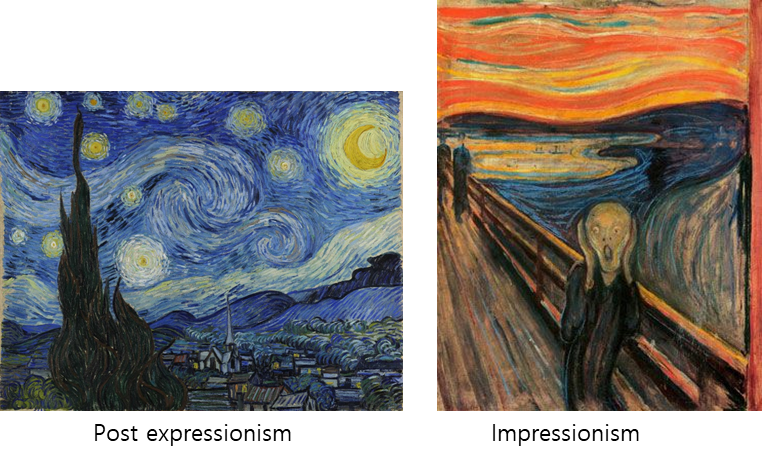

#### 1.5 Implementation on new data

In [ ]:
### visualize on new data --- probably style, genre, and similarity at once? 

#### 1.6 Image Segmentation

In [14]:
#### image segmentation advantage(reported by literature)..... 
# results

### 2. Genre Classification Model

### 3. Artwork Recommender